In [60]:
!pip install PyWavelets
!pip install pyfeats

     |████████████████████████████████| 5.7 MB 8.5 MB/s 
  Created wheel for pyfeats: filename=pyfeats-0.0.11-py3-none-any.whl size=46825 sha256=48af86b763ccf229d247caaa5a6f7448fc7817f94f5e6e0c23db43941d5ec57a
  Stored in directory: /root/.cache/pip/wheels/a2/d6/20/ffb98b47157e97a3fe0db4ea16c258986aa0ee386ecc7dbf80
Successfully built pyfeats


In [61]:
import pandas as pd
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from PIL import Image, ImageFilter

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp "/content/drive/MyDrive/CS5100 Project/resized_images_v4_224.zip" -r "/content/resized_images_v4_224.zip"
!unzip /content/resized_images_v4_224.zip -d /content/resized_images_v4_224

In [64]:
import pickle

def write_dataframe(df, extract_path, first = False):
  mode = 'a'
  header = False
  if first:
    mode = 'w'
    header = True
  
  df.to_csv(extract_path, mode = mode, header = header, index = False)  
  return


def read_pickle_file(filepath):
  with open(filepath, "rb") as f:
    return pickle.load(f)
  
def write_pickle_file(df, extract_path, iteration):

  with open(extract_path,'wb') as f:
    pickle.dump([df,iteration], f)
    first = False
    if iteration == 500:
      first = True
    
  extract_path2 = extract_path.replace(".pkl",".csv")
  write_dataframe(df, extract_path2, first)
  return

In [96]:
# add this from GIT
filepath = "/content/class_dict_wo_NF.pkl"
class_dict = read_pickle_file(filepath)

In [97]:
#add this from GIT
df = pd.read_csv("/content/final_df_all_images_wo_NF_labels.csv")

In [98]:
df.tail()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec
112115,00030801_001.png,"['Mass', 'Pneumonia']",1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,0,0,0,0,0,0,0,0,0,1,0,0,1,0,[0 0 0 0 0 0 0 0 0 1 0 0 1 0]
112116,00030802_000.png,['No Finding'],0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
112117,00030803_000.png,['No Finding'],0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
112118,00030804_000.png,['No Finding'],0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
112119,00030805_000.png,['No Finding'],0,30805,27,M,PA,2048,2500,0.171,0.171,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [99]:
df["image_path"] = "/content/resized_images_v4_224/resized_images_v4_224/" + df["Image Index"]

In [100]:
X, y = df["image_path"], df["disease_vec"]

In [73]:
# HOG - Histogram of Oriented Gradients
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

def hog_features(path):
  # reading the image
  img = imread(path)
  img = rgb2gray(img)
  resized_img = resize(img, (224,224))
  exposure_balanced_image = exposure.rescale_intensity(resized_img, in_range=(0, 225), out_range=(0, 225))
  fd = hog(exposure_balanced_image, orientations=4, pixels_per_cell=(8, 8),
                	cells_per_block=(1, 1), visualize=False, multichannel=False)
  return (fd , exposure_balanced_image)

In [74]:
# LBP- Local Binary Pattern
from skimage.feature import local_binary_pattern
from skimage import data

def LBP(exposure_balanced_image, radius = 3):

  n_points = 8 * radius
  lbp = local_binary_pattern(exposure_balanced_image, n_points, radius, method = 'uniform')
  n_bins = int(lbp.max() + 1)
  histogram_2 = np.histogram(lbp.ravel(), density = True, bins = n_bins, range=(0, n_bins))

  return histogram_2[0]

In [75]:
# Gray level co-occurance matrix

import numpy as np
from skimage.feature import greycomatrix, greycoprops
from skimage import io, color, img_as_ubyte

def GLCM(image):
  image = img_as_ubyte(image)

  bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255]) #16-bit
  inds = np.digitize(image, bins)

  max_value = inds.max()+1
  matrix_coocurrence = greycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=False, symmetric=False)
  # plt.imshow(matrix_coocurrence[0], cmap = 'gray')
  

  # GLCM properties
  def contrast_feature(matrix_coocurrence):
      contrast = greycoprops(matrix_coocurrence, 'contrast')
      return contrast

  def dissimilarity_feature(matrix_coocurrence):
      dissimilarity = greycoprops(matrix_coocurrence, 'dissimilarity')    
      return dissimilarity

  def homogeneity_feature(matrix_coocurrence):
      homogeneity = greycoprops(matrix_coocurrence, 'homogeneity')
      return homogeneity

  def energy_feature(matrix_coocurrence):
      energy = greycoprops(matrix_coocurrence, 'energy')
      return energy

  def correlation_feature(matrix_coocurrence):
      correlation = greycoprops(matrix_coocurrence, 'correlation')
      
      return correlation

  def entropy_feature(matrix_coocurrence):
      entropy = greycoprops(matrix_coocurrence, 'entropy')
      return entropy

  # print(contrast_feature(matrix_coocurrence))
  # print(dissimilarity_feature(matrix_coocurrence))
  # print(homogeneity_feature(matrix_coocurrence))
  # print(energy_feature(matrix_coocurrence))
  # print(correlation_feature(matrix_coocurrence))
  return np.concatenate((contrast_feature(matrix_coocurrence),dissimilarity_feature(matrix_coocurrence),homogeneity_feature(matrix_coocurrence),energy_feature(matrix_coocurrence),correlation_feature(matrix_coocurrence)), axis = 1)


In [76]:
import pywt
import pywt.data
def wavelet_transform(image):

  coef = pywt.wavedec2(image, 'db1' , level=4) # level3 decomposition #use db1 or haar

  cA = coef[0]
  (cH1,cV1,cD1) =  coef[-1]#level1
  (cH2,cV2,cD2) =  coef[-2]#level2
  (cH3,cV3,cD3) =  coef[-3]#level3
  (cH4,cV4,cD4) =  coef[-4]#level4 output of level4 decomp and furthur level dont offer better features

  return np.concatenate((cA.reshape(1,-1),cH4.reshape(1,-1),cV4.reshape(1,-1),cD4.reshape(1,-1)), axis = 1)


In [113]:
import tqdm
import gc
def extract_features(dataset, extract_path, name, chunk_size = 500, start_index = 0):
  return_df = pd.DataFrame()
  extract_path = extract_path + "_" + name + ".csv"
  for i in tqdm.tqdm(range(start_index,dataset.shape[0])):
    lst = list()
    path = dataset[i]
    hgf = hog_features(path)
    fd, exposure_balanced_image = hgf[0].reshape(1,-1) , hgf[1]
    hist = LBP(exposure_balanced_image).reshape(1,-1)
    covariance_matrix = GLCM(exposure_balanced_image)
    wt = wavelet_transform(exposure_balanced_image)
    lst = np.float32(np.concatenate((covariance_matrix, hist, wt, fd), axis = 1))
    # return_df = np.concatenate([return_df, lst])
    df = pd.DataFrame(lst)
    return_df = pd.concat([return_df, df], ignore_index = True, copy = False)
  #   if i!=0 and i % chunk_size == 0:
  #     print("chunking",i)
  #     header = False
  #     mode = 'a'
  #     if i == chunk_size:
  #       header = True
  #       mode = 'w'
  #     x = pd.DataFrame(return_df)
  #     x.to_csv(extract_path, mode = mode, header = header, index = False)
  #     del return_df
  #     gc.collect()
  #     return_df = np.empty((0,830))
  
  # if return_df.shape[0] != 0:
  #   x = pd.DataFrame(return_df)
  #   x.to_csv(extract_path, mode = 'a', header = False, index = False)
  #   del return_df
  #   gc.collect()
  return_df.to_csv(extract_path, index = False) 
  # return_df = pd.read_csv(extract_path)

  return return_df
  # return_df = pd.DataFrame(return_df)
  # return_df.to_csv(extract_path, index = False)
  # return return_df

In [114]:
extract_path = "/content/drive/MyDrive/CS5100 Project/manual_features_v2"
x2 = extract_features(X, extract_path, "all")

  0%|          | 0/112120 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  if sys.path[0] == '':
  0%|          | 12/112120 [00:01<3:36:54,  8.61it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  if sys.path[0] == '':
  5%|▍         | 5374/112120 [10:21<3:25:37,  8.65it/s]


KeyboardInterrupt: ignored

In [111]:
fd.shape[1] + hist.shape[1] + covariance_matrix.shape[1] + wt.shape[1]

3966

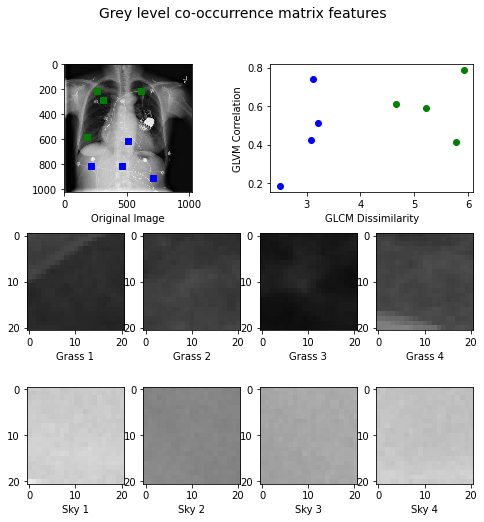

In [ ]:
import matplotlib.pyplot as plt

from skimage.feature import greycomatrix, greycoprops
from skimage import data


PATCH_SIZE = 21

# open the camera image
path = '/content/00000075_000.png'
image = io.imread(path)

# select some patches from grassy areas of the image
grass_locations = [(200, 250), (570, 170), (275, 300), (200, 600)]
grass_patches = []
for loc in grass_locations:
    grass_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                               loc[1]:loc[1] + PATCH_SIZE])

# select some patches from sky areas of the image
sky_locations = [(600, 500), (900, 700), (800, 200), (800, 450)]
sky_patches = []
for loc in sky_locations:
    sky_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                             loc[1]:loc[1] + PATCH_SIZE])

# compute some GLCM properties each patch
xs = []
ys = []
for patch in (grass_patches + sky_patches):
    glcm = greycomatrix(patch, [5], [0], 256, symmetric=True, normed=True)
    xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(greycoprops(glcm, 'correlation')[0, 0])

# create the figure
fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(image, cmap=plt.cm.gray, interpolation='nearest',
          vmin=0, vmax=255)
for (y, x) in grass_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for (y, x) in sky_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(xs[:len(grass_patches)], ys[:len(grass_patches)], 'go',
        label='Grass')
ax.plot(xs[len(grass_patches):], ys[len(grass_patches):], 'bo',
        label='Sky')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLVM Correlation')

# display the image patches
for i, patch in enumerate(grass_patches):
    ax = fig.add_subplot(3, len(grass_patches), len(grass_patches)*1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray, interpolation='nearest',
              vmin=0, vmax=255)
    ax.set_xlabel('Grass %d' % (i + 1))

for i, patch in enumerate(sky_patches):
    ax = fig.add_subplot(3, len(grass_patches), len(grass_patches)*2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray, interpolation='nearest',
              vmin=0, vmax=255)
    ax.set_xlabel('Sky %d' % (i + 1))


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14)
plt.show()